In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use('ggplot')
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['savefig.dpi'] = 200
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'lightgrey'

In [2]:
pd.set_option('display.max_columns', None)

pop_spotify = pd.read_pickle("data/spotify_df.pkl")

In [3]:
pop_spotify.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,month
95157,2c07kosP5G3qP4vHhwoUMT,In And Out Of Love - ilan Bluestone & Maor Lev...,30,263432,0,"['Armin van Buuren', 'Sharon Den Adel', 'Ilan ...","['0SfsnGyD8FpIN4U4WCkBZ5', '2GST08xzn3dJilysjD...",2020-12-11,0.352,0.736,1,-4.781,1,0.1300,0.01930,0.000020,0.3600,0.102,129.987,4,2020,12
87847,1wd5l8qYJ4AlgAhPGQxZq4,Im,30,228069,0,['Alma Zohar'],['61Sbigb2Faz8K27wBoOBo9'],2015-07-15,0.702,0.572,7,-9.597,1,0.0289,0.25900,0.000000,0.0946,0.327,129.985,4,2015,7
86833,3n1vpIDGakzAbo2p2etvhN,Taras e manias,30,248813,0,['Marco Paulo'],['5LxTQtpFwvokioLWNkrDQr'],2013-01-14,0.613,0.558,11,-6.149,1,0.0387,0.53200,0.000000,0.1260,0.529,110.069,4,2013,1
95155,0MbIwfFvlLpK2yW6w3kmbd,Time Machine (Mixed),30,49676,0,"['Craig Connelly', 'Tara Louise']","['78UUH1buA0gDtDnkX2dPgL', '6rCzXE6L3H7Eihb4Bg...",2020-12-11,0.508,0.887,4,-8.721,0,0.1370,0.00441,0.987000,0.1270,0.648,135.215,4,2020,12
79426,6WmvWYAnshYAAXZRD1hqck,Eime Enas Allos - Original,30,214693,0,['Nino Xypolitas'],['1ATDcv6wTF2U42HPB4qEFz'],2006-01-01,0.644,0.996,11,-5.938,1,0.1030,0.00346,0.000001,0.3680,0.517,142.995,4,2006,1


In [4]:
samp = np.random.randint(low=0,high=1900000,size=100000)
samp

array([1179386,  104950,  552228, ...,  121020,  204891,  331801])

In [5]:
sample_df = pop_spotify.iloc[samp]

In [6]:
samp_df2 = sample_df[['popularity','duration_ms','explicit','danceability','energy','key','loudness','mode', 'speechiness','acousticness','instrumentalness','liveness','valence','tempo','year']]

In [7]:
# pop_df = pop_spotify[['popularity','danceability', 'instrumentalness', 'loudness', 'speechiness', 'explicit','liveness','duration_ms']]

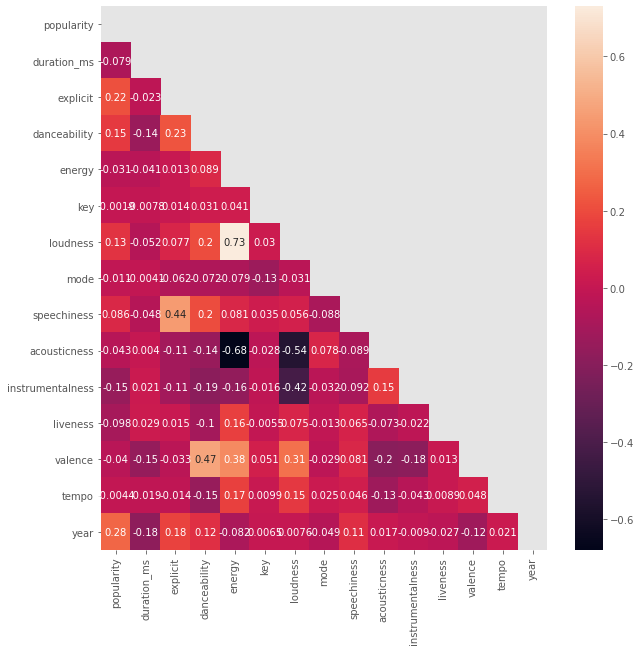

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(samp_df2.corr(), annot=True, mask=np.triu(samp_df2.corr()));

In [9]:
# dance = pop_df[['popularity','danceability']]
# avg_dance = pop_df.groupby('popularity').mean()

In [10]:
# fig, ax = plt.subplots(figsize=(14,5),squeeze=True)

# ax.plot(avg_dance.index, avg_dance.danceability,color='navy',alpha=0.5)
# ax.scatter(avg_dance.index, avg_dance.danceability,color='blue',s=20)
# ax.set_title('Average Danceability as Popularity Increases')
# ax.set_xlabel('Popularity')
# ax.set_ylabel('Danceability')
# plt.plot(np.unique(avg_dance.index), np.poly1d(np.polyfit(avg_dance.index, avg_dance.danceability, 1))(np.unique(avg_dance.index)),linestyle='--');
# plt.tight_layout()
# plt.show()

In [11]:
# r,p = stats.pearsonr(avg_dance.index,avg_dance.danceability)
# r,p

In [12]:
def rmse(y_true, y_predict):
    return mean_squared_error(y_true, y_predict, squared=False)

In [13]:
def cross_val(X_train, y_train, k, model):
    # Return the error for k-fold cross-val
    kf = KFold(n_splits=k)
    error = np.empty(k)
    index = 0
    
    for train, test in kf.split(X_train):
        model.fit(X_train[train], y_train[train])
        pred = model.predict(X_train[test])
        error[index] = rmse(y_train[test], pred)
        index +=1
    return np.mean(error)

In [14]:
y = samp_df2.popularity
X = samp_df2.drop(['popularity'], axis=1)


In [15]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF')

,VIF,Columns
9,1.432681,instrumentalness
1,1.626963,explicit
7,2.449735,speechiness
10,2.566453,liveness
6,2.795311,mode
4,3.278127,key
8,3.547640,acousticness
11,9.098874,valence
0,11.237158,duration_ms
5,12.776499,loudness


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, shuffle=True, test_size=0.2, random_state=42)

In [17]:
lr = LinearRegression().fit(X_train, y_train)
# y_hats = lr.predict(X_train)
lr.score(X_test,y_test)

0.15030220597139388

In [18]:
ridge1 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge1.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge1.score(X_test, y_test)))

Training set score: 0.15
Test set score: 0.15


In [19]:
ridge2 = Ridge(alpha=.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge2.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge2.score(X_test, y_test)))

Training set score: 0.15
Test set score: 0.15


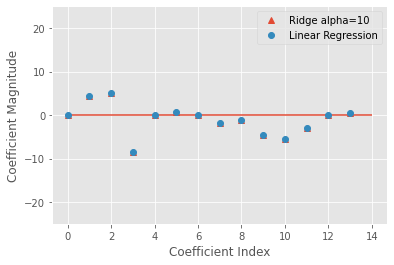

In [20]:
plt.plot(ridge1.coef_,'^',label="Ridge alpha=10")
plt.plot(lr.coef_,'o', label="Linear Regression")

plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Magnitude")
plt.hlines(0,0,len(lr.coef_))
plt.ylim(-25, 25)
plt.legend()

# Random Forest


n_estimators:
200: .79532
100: .79234
50: .79260
400: .796

In [63]:
# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [16,32,64,128]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}



In [64]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=3,random_state=42, n_jobs=-1)
# rf_random.fit(X_train,y_train)

## Training

In [65]:
rfr = RandomForestRegressor(n_estimators=50)
model = rfr.fit(X_train,y_train)
y_hats = model.predict(X_train)
print('Accuracy Test:', model.score(X_train,y_train))
print('RMSE Train:', rmse(y_train, y_hats))

Accuracy Test: 0.9631009252963711
RMSE Train: 2.1917971828198555


### Cross-validation on training data

In [66]:
# print('Cross-validation Train:', cross_val(X_train, y_train, k=7, model=RandomForestRegressor()))

## Testing

In [67]:
y_hats = model.predict(X_test)
print('Accuracy Test:', model.score(X_test,y_test))
print('RMSE Test:', rmse(y_test,y_hats))

Accuracy Test: 0.8116785757142968
RMSE Test: 4.95901162794916


* With **Testing Accuracy** < **Training Accuracy**, this indicates an overfitting of the model. Need to generalize the model more.

### Cross-validation on testing data

In [68]:
# print('Cross-validation Test:', cross_val(X_test, y_test, k=7, model=RandomForestRegressor()))

# Neural Network

In [72]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [73]:
model = Sequential()

In [77]:
# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 6))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

In [78]:
#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [79]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


ValueError: in user code:

    /home/atlas/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:830 train_function  *
        return step_function(self, iterator)
    /home/atlas/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:813 run_step  *
        outputs = model.train_step(data)
    /home/atlas/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:770 train_step  *
        y_pred = self(x, training=True)
    /home/atlas/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/atlas/anaconda3/lib/python3.7/site-packages/keras/engine/input_spec.py:248 assert_input_compatibility  *
        raise ValueError(

    ValueError: Input 0 of layer sequential_27 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (32, 14)
